## Import

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import os
import math

import matplotlib.pyplot as plt;

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
destination_dir = '/content/drive/MyDrive/fruit_dataset'
train_dir = os.path.join(destination_dir, 'train')
validation_dir = os.path.join(destination_dir, 'validation')
test_dir = os.path.join(destination_dir, 'test')

In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.5, 1.0],
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)
validation_datagen = ImageDataGenerator(rescale=1./255)


## Image Data Generator

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    target_size=(224,224),
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=32,
                                                         color_mode="rgb",
                                                         target_size=(224,224),
                                                         class_mode='binary')

Found 1048 images belonging to 2 classes.
Found 351 images belonging to 2 classes.


# Transfer Learning

In [ ]:
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = Dropout(0.3)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
train_len = 0
for foldername in os.listdir(os.path.join(destination_dir, 'train')):
    train_len = train_len + len(os.listdir(os.path.join(destination_dir,'train',foldername)))

val_len = 0
for foldername in os.listdir(os.path.join(destination_dir, 'validation')):
    val_len = val_len + len(os.listdir(os.path.join(destination_dir, 'validation',foldername)))

print(train_len)
print(val_len)

1048
351


## Custom Callbacks function

In [ ]:
epochs = 30
batch_size = 32

checkpoint_filepath = os.path.join(
    '/content/drive/MyDrive/dfr/checkpoints',
    "{epoch:03d}-{val_loss:.4f}.h5",
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=4, restore_best_weights=True)

callbacks = [checkpoint, early_stopping]

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=(train_len/batch_size),
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=(val_len/batch_size)
)

Epoch 1/30
33/32 [==============================] - ETA: -1s - loss: 4.1848 - accuracy: 0.7901

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 294s 9s/step - loss: 4.1848 - accuracy: 0.7901 - val_loss: 2.1938 - val_accuracy: 0.8889
Epoch 2/30
32/32 [==============================] - 21s 634ms/step - loss: 1.8356 - accuracy: 0.8826 - val_loss: 1.4395 - val_accuracy: 0.9345
Epoch 3/30
32/32 [==============================] - 21s 630ms/step - loss: 1.3297 - accuracy: 0.8989 - val_loss: 1.1006 - val_accuracy: 0.9516
Epoch 4/30
32/32 [==============================] - 20s 613ms/step - loss: 0.9852 - accuracy: 0.9227 - val_loss: 0.8350 - val_accuracy: 0.9259
Epoch 5/30
32/32 [==============================] - 21s 653ms/step - loss: 0.7589 - accuracy: 0.9342 - val_loss: 0.6837 - val_accuracy: 0.9345
Epoch 6/30
32/32 [==============================] - 20s 613ms/step - loss: 0.7028 - accuracy: 0.8998 - val_loss: 0.5777 - val_accuracy: 0.9459
Epoch 7/30
32/32 [==============================] - 21s 637ms/step - loss: 0.5719 - accuracy: 0.9265 - val_loss: 0.5141 - val_accuracy: 0.9373
Epoch 8/30
3

<Figure size 640x480 with 0 Axes>

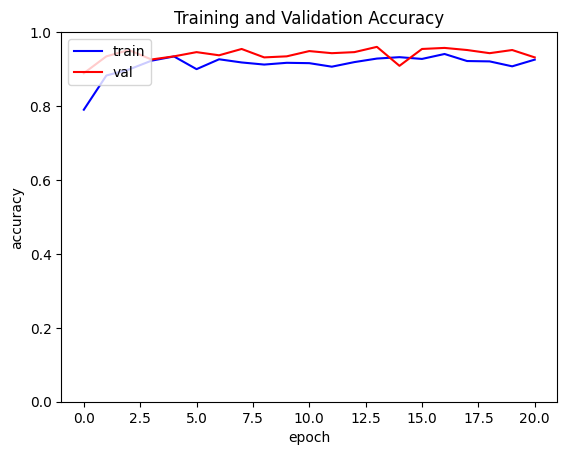

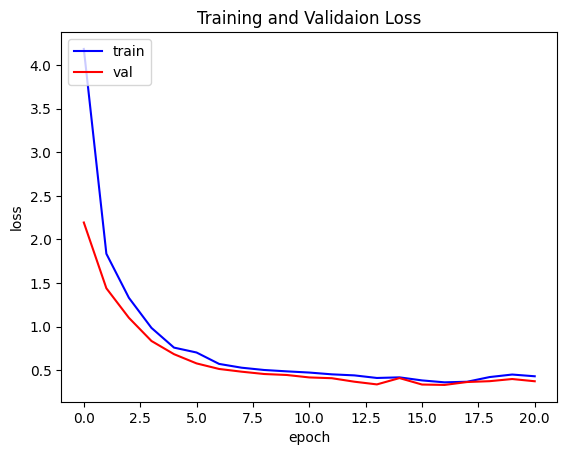

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0, 1)
plt.figure()

plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.figure()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(224, 224),
                                                  shuffle = False,
                                                  class_mode='binary')

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)
print('loss test: ',loss)

Found 349 images belonging to 2 classes.
349/349 [==============================] - 65s 183ms/step - loss: 0.3161 - accuracy: 0.9513
accuracy test:  0.9512894153594971
loss test:  0.3160748779773712


In [ ]:
model.save('mobilenet_final0402.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### This cell is being run on Google Colab. Please ignore this cell if you are not using Google Colab

Saving testimage.jpg to testimage.jpg
Saving 20240401_191051.jpg to 20240401_191051.jpg
Saving 20240401_191041.jpg to 20240401_191041.jpg
Saving 20240401_191036.jpg to 20240401_191036.jpg
1/1 [==============================] - 0s 36ms/step


<ipython-input-18-d70867acfec0>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title = f"predict: {predict_result[n]} ({round(float(image_conf[n])*100, 2)}%)"


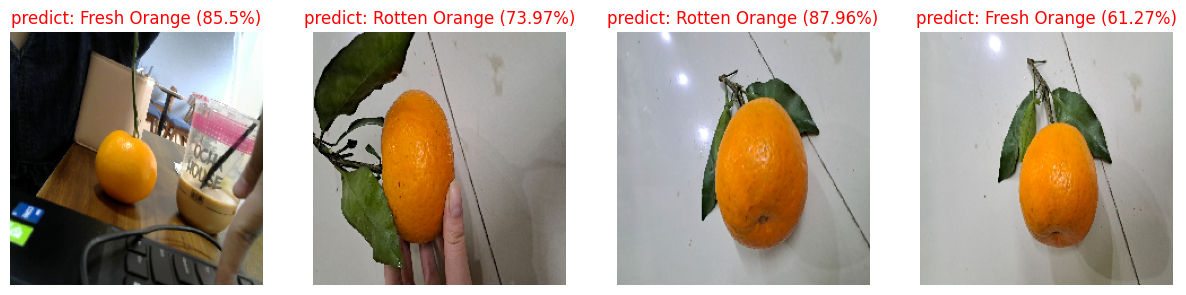

In [ ]:
from keras.utils import get_file
import pathlib
import cv2
from google.colab import files #USING IN COLAB
from keras.preprocessing import image
import numpy as np

model_predict = tf.keras.models.load_model('mobilenet_final0402.h5')
model_predict.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

uploaded = files.upload()
image_name = []
image_conf = []
predict_result = []

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(224, 224), interpolation="nearest")
  # imgplot = plt.imshow(img)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  images = np.vstack([img])
  classes = model_predict.predict(images, batch_size=10)
  label = np.where(classes[0] > 0.5, 1,0)
  # print(label)
  if label == 0:
    image_name.append(fn)
    image_conf.append(1.0 - classes[0])
    predict_result.append('Fresh Orange')
  else:
    image_name.append(fn)
    image_conf.append(classes[0])
    predict_result.append('Rotten Orange')

plt.figure(figsize=(15, 15))
for n in range(len(image_name)):
  plt.subplot((math.ceil(len(image_name)/4))+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image.load_img(image_name[n], color_mode="rgb", target_size=(224, 224), interpolation="nearest"))
  title = f"predict: {predict_result[n]} ({round(float(image_conf[n])*100, 2)}%)"
  if predict_result[n] == 'Fresh Fruit':
    plt.title(title, color='black')
  else:
    plt.title(title, color='red')

  plt.axis('off')
plt.show()

for fn in image_name:
  os.system(f'rm {fn}')

## Test Set Classification Report

In [ ]:
from sklearn.metrics import classification_report

test_predictions = model.predict(test_generator)
predicted_classes = (test_predictions > 0.5).astype(int)

true_labels = test_generator.classes

print("Test Set Classification Report:")
print(classification_report(true_labels, predicted_classes))

349/349 [==============================] - 5s 12ms/step
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       100
           1       0.99      0.94      0.97       249

    accuracy                           0.95       349
   macro avg       0.93      0.96      0.94       349
weighted avg       0.95      0.95      0.95       349



# TEST DETECTION AND PREDICTION

#### Predict function

In [ ]:
from keras.models import load_model
from keras.preprocessing import image

model = load_model("mobilenet_final0402.h5")

def predict_and_display(image_path):
    img = image.load_img(image_path, color_mode="rgb", target_size=(224, 224), interpolation="nearest")
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Chuan hoa

    prediction = model.predict(img)

    label = "Fresh Orange" if prediction[0][0] > 0.5 else "Rotten Orange"
    confidence = prediction[0][0] if label == "Fresh Orange" else 1.0 - prediction[0][0]

    plt.imshow(image.load_img(image_path, color_mode="rgb", target_size=(224, 224), interpolation="nearest"))
    title = f"Prediction: {label} ({round(float(confidence) * 100, 2)}%)"
    if label == 'Fresh Orange':
        plt.title(title, color='black')
    else:
        plt.title(title, color='red')
    plt.axis('off')
    plt.show()


#### Detect object program

In [ ]:
import cv2
import time
import numpy as np
from random import randint

CAMERA_DEVICE_ID = 1 # 1 for webcam and 0 for laptop's camera
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 240
fps = 0


def visualize_fps(image, fps: int):
    if len(np.shape(image)) < 3:
        text_color = (255, 255, 255)  # white
    else:
        text_color = (0, 255, 0)  # green
    row_size = 20  # pixels
    left_margin = 24  # pixels

    font_size = 1
    font_thickness = 1

    # Draw the FPS counter
    fps_text = 'FPS = {:.1f}'.format(fps)
    text_location = (left_margin, row_size)
    cv2.putText(image, fps_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                font_size, text_color, font_thickness)

    return image

1/1 [==============================] - 0s 229ms/step


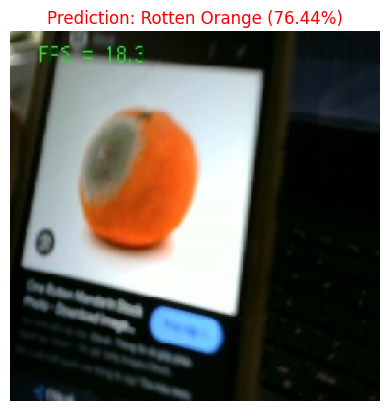

1/1 [==============================] - 0s 61ms/step


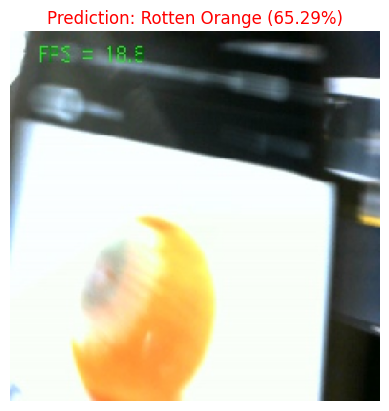

1/1 [==============================] - 0s 59ms/step


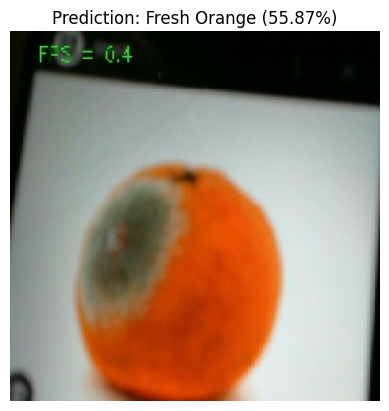

1/1 [==============================] - 0s 55ms/step


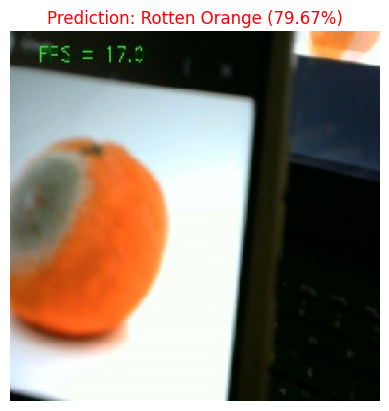

1/1 [==============================] - 0s 61ms/step


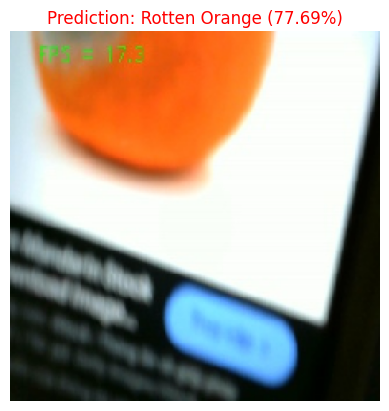

1/1 [==============================] - 0s 48ms/step


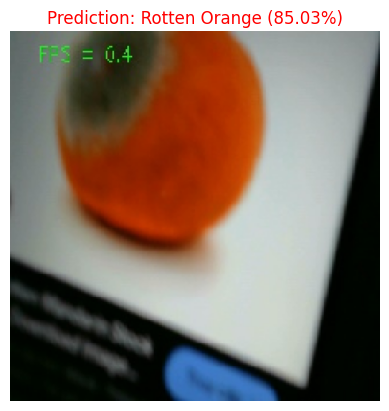

1/1 [==============================] - 0s 65ms/step


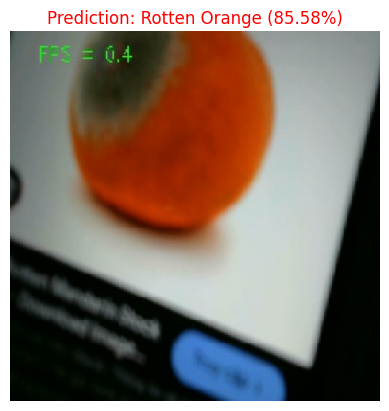

1/1 [==============================] - 0s 44ms/step


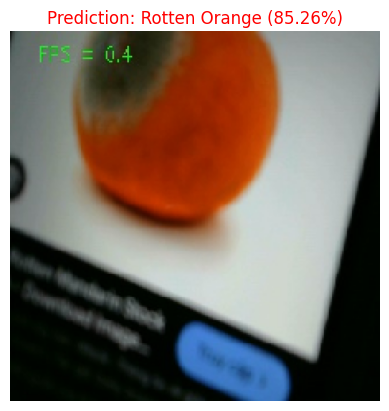

1/1 [==============================] - 0s 50ms/step


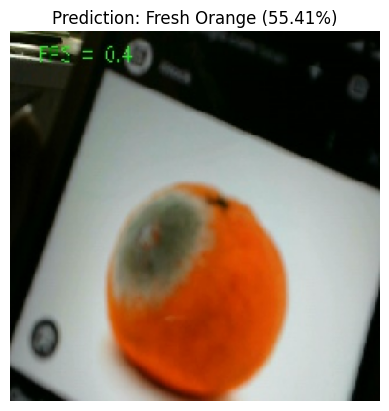

In [ ]:
try:
    # create video capture
    cap = cv2.VideoCapture(CAMERA_DEVICE_ID)

    # set resolution to 320x240 to reduce latency
    cap.set(3, IMAGE_WIDTH)
    cap.set(4, IMAGE_HEIGHT)

    capture_image = False  # Flag to capture image when True

    # Load the object detection model
    with open('coco.names','rt') as f:
        class_names = f.read().rstrip('\n').split('\n')

    class_colors = []
    for i in range(len(class_names)):
        class_colors.append((randint(0,255), randint(0,255), randint(0,255)))

    model_path = 'ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
    weight_path = 'frozen_inference_graph.pb'

    net = cv2.dnn_DetectionModel(weight_path, model_path)
    net.setInputSize(320, 320)
    net.setInputScale(1.0/127.5)
    net.setInputMean((127.5, 127.5, 127.5))
    net.setInputSwapRB(True)

    # Loop to continuously get images
    while True:
        # Record start time
        start_time = time.time()

        # Read the frame from the camera
        _, frame = cap.read()

        # Object detection
        classIds, confs, bbox = net.detect(frame, confThreshold=0.5)
        if len(classIds) != 0:
            for classId, confidence, box in zip(classIds.flatten(), confs.flatten(), bbox):
                # Check if the detected object is 'orange'
                if class_names[classId-1].lower() == 'orange':
                    capture_image = True  # Set flag to True

        # Display frame with FPS
        frame_with_fps = visualize_fps(frame, fps)
        cv2.imshow('Object Detection', frame_with_fps)

        # If capture_image flag is True and any key is pressed, save the image
        if capture_image:
            cv2.imwrite('orange_detected.jpg', frame_with_fps)
            predict_and_display('orange_detected.jpg')
            capture_image = False  # Reset the flag
            time.sleep(2)  # Optional delay to prevent multiple captures

        # Record end time
        end_time = time.time()

        # Calculate FPS
        seconds = end_time - start_time
        fps = 1.0 / seconds
        # print("Estimated FPS: {:.1f}".format(fps))

        # Check for 'Esc' key press to exit the loop
        if cv2.waitKey(1) == 27:
            break

except Exception as e:
    print(e)

finally:
    # Clean up and exit the program
    cv2.destroyAllWindows()
    cap.release()


In [ ]:
import keras
keras.__version__

'2.15.0'

## TEST TF Lite

### Convert to TFLite

In [ ]:
keras_model = tf.keras.models.load_model("/content/drive/MyDrive/0204/mobilenet_final0402.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT] # sử dụng optimization nếu cần tối ưu thêm
tflite_model = converter.convert()
with open('model_mobilenetv2.tflite', 'wb') as f:
  f.write(tflite_model)


#### Sử dụng optimization và không

Saving 1.PNG to 1.PNG
Saving 2.PNG to 2.PNG


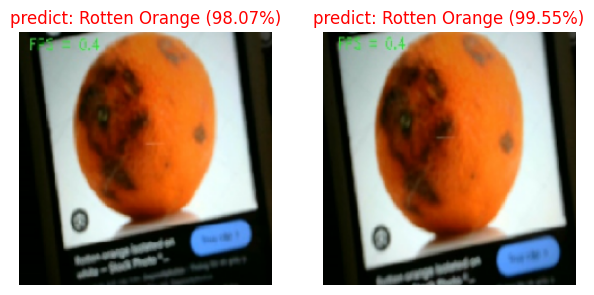

In [ ]:
import tensorflow as tf
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from google.colab import files

# Load mô hình TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path="/content/model_mobilenetv2_optimized.tflite")
interpreter.allocate_tensors()

# Lấy thông số của đầu vào và đầu ra
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

uploaded = files.upload()
image_name = []
image_conf = []
predict_result = []

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(224, 224), interpolation="nearest")
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  # Chuẩn bị dữ liệu đầu vào cho mô hình TensorFlow Lite
  interpreter.set_tensor(input_details[0]['index'], img)

  # Chạy inference
  interpreter.invoke()

  # Lấy kết quả
  output_data = interpreter.get_tensor(output_details[0]['index'])

  # Xử lý kết quả dự đoán
  label = np.where(output_data > 0.5, 1, 0)[0][0]
  confidence = output_data[0][0] if label == 1 else 1.0 - output_data[0][0]

  if label == 0:
    predict_result.append('Fresh Orange')
  else:
    predict_result.append('Rotten Orange')

  image_name.append(fn)
  image_conf.append(confidence)

plt.figure(figsize=(15, 15))
for n in range(len(image_name)):
  plt.subplot((math.ceil(len(image_name)/4))+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image.load_img(image_name[n], color_mode="rgb", target_size=(224, 224), interpolation="nearest"))
  title = f"predict: {predict_result[n]} ({round(float(image_conf[n])*100, 2)}%)"
  if predict_result[n] == 'Fresh Orange':
    plt.title(title, color='black')
  else:
    plt.title(title, color='red')

  plt.axis('off')
plt.show()

for fn in image_name:
  os.system(f'rm {fn}')


#### Không sử dụng optimization

Saving 20240401_191051 - Copy.jpg to 20240401_191051 - Copy (1).jpg
Saving 20240401_191051.jpg to 20240401_191051.jpg
Saving 20240401_191041 - Copy.jpg to 20240401_191041 - Copy (1).jpg
Saving images (11).jfif to images (11) (1).jfif
Saving images (10).jfif to images (10) (1).jfif
Saving images (9).jfif to images (9).jfif
Saving download (3).jfif to download (3) (2).jfif
Saving images (8).jfif to images (8) (1).jfif
Saving images (6).jfif to images (6) (1).jfif
Saving images (5).jfif to images (5) (2).jfif
Saving images (3).jfif to images (3).jfif
Saving download (1).jfif to download (1) (1).jfif


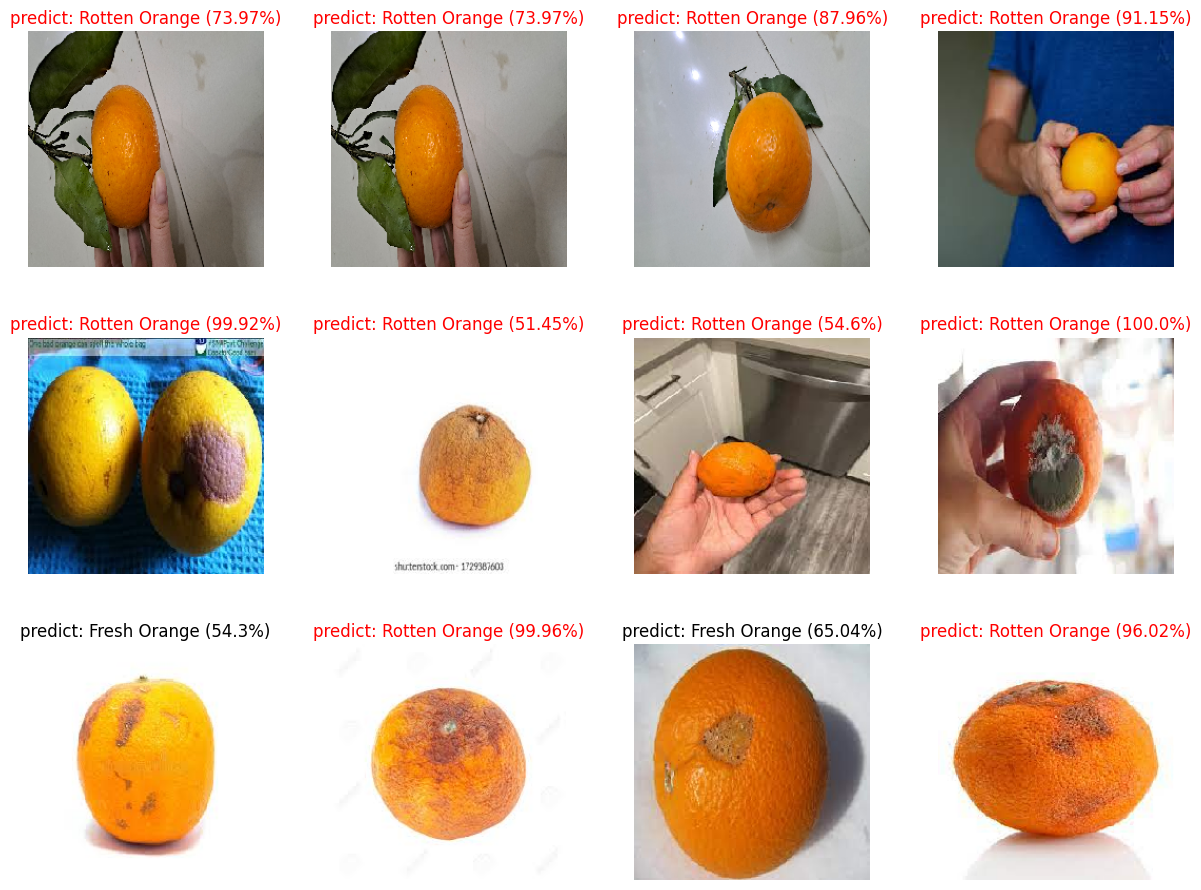

In [ ]:
import tensorflow as tf
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from google.colab import files

# Load mô hình TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path="/content/model_mobilenetv2.tflite")
interpreter.allocate_tensors()

# Lấy thông số của đầu vào và đầu ra
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

uploaded = files.upload()
image_name = []
image_conf = []
predict_result = []

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, color_mode="rgb", target_size=(224, 224), interpolation="nearest")
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img/255

  # Chuẩn bị dữ liệu đầu vào cho mô hình TensorFlow Lite
  interpreter.set_tensor(input_details[0]['index'], img)

  # Chạy inference
  interpreter.invoke()

  # Lấy kết quả
  output_data = interpreter.get_tensor(output_details[0]['index'])

  # Xử lý kết quả dự đoán
  label = np.where(output_data > 0.5, 1, 0)[0][0]
  confidence = output_data[0][0] if label == 1 else 1.0 - output_data[0][0]

  if label == 0:
    predict_result.append('Fresh Orange')
  else:
    predict_result.append('Rotten Orange')

  image_name.append(fn)
  image_conf.append(confidence)

plt.figure(figsize=(15, 15))
for n in range(len(image_name)):
  plt.subplot((math.ceil(len(image_name)/4))+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image.load_img(image_name[n], color_mode="rgb", target_size=(224, 224), interpolation="nearest"))
  title = f"predict: {predict_result[n]} ({round(float(image_conf[n])*100, 2)}%)"
  if predict_result[n] == 'Fresh Orange':
    plt.title(title, color='black')
  else:
    plt.title(title, color='red')

  plt.axis('off')
plt.show()

for fn in image_name:
  os.system(f'rm {fn}')
